In [1]:
import datetime
import backtrader as bt
import pandas as pd
import requests as re
import quantstats
import clickhouse_connect
import warnings
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from models.regression import regression_trend_analysis
import sklearn
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Загрузка данных

In [12]:
def return_data(ticker,test_size=0.2):
    df = pd.read_csv(f'data/{ticker}.csv',sep=',')
    df = df.set_index('datatime')
    df = df.fillna(0)
    del(df['symbol'])
    test = int(len(df)*(1-test_size))
    return df[:test].copy() , df[test:].copy()

def data_processing(df):
    X_data = df[[column for column in df.columns if not (column in IGNORE_COLUMNS)]]
    X_data.drop (index=X_data.index[0],axis=0,inplace=True)
    Y_data = df['pr_change']
    Y_data.drop (index=Y_data.index[len(Y_data)-1],axis=0,inplace=True)
    return X_data , Y_data

def classification(x):
    if x>0:
        return 1
    else:
        return 0
    
IGNORE_COLUMNS = ['symbol','tradetime','open','high','low','close']

In [13]:
df_train , df_val  = return_data('SBER')

# Предобработка

In [14]:
#в качестве гипотезы в дополнении к данным добавим информацию о наличии тренда, через регрессионный анализ
#дало прибавку в точности на валидации +3%
rolling = 10
df_train['trend'] = df_train['close'].rolling(rolling).apply(regression_trend_analysis)
df_val['trend'] = df_val['close'].rolling(rolling).apply(regression_trend_analysis)
df_train['trend'] = df_train['trend'].fillna(df_train['trend'].mean())
df_val['trend'] = df_val['trend'].fillna(df_val['trend'].mean())

X , Y = data_processing(df_train)
X_val , Y_val = data_processing(df_val)
metriks = list(X.columns)
Y_reg = Y.copy()
Y = Y.apply(classification)
Y_val_reg = Y_val.copy()
Y_val = Y_val.apply(classification)

_mean = X.mean()
_std = X.std()

X = (X-X.mean())/X.std()
X_val = (X_val-_mean)/_std
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70670 entries, 2020-01-16 10:10:00 to 2023-03-07 16:40:00
Data columns (total 55 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pr_std             70670 non-null  float64
 1   vol                70670 non-null  float64
 2   val                70670 non-null  float64
 3   trades             70670 non-null  float64
 4   pr_vwap            70670 non-null  float64
 5   pr_change          70670 non-null  float64
 6   trades_b           70670 non-null  float64
 7   trades_s           70670 non-null  float64
 8   val_b              70670 non-null  float64
 9   val_s              70670 non-null  float64
 10  vol_b              70670 non-null  float64
 11  vol_s              70670 non-null  float64
 12  disb               70670 non-null  float64
 13  pr_vwap_b          70670 non-null  float64
 14  pr_vwap_s          70670 non-null  float64
 15  put_orders_b       70670 non-null  float64


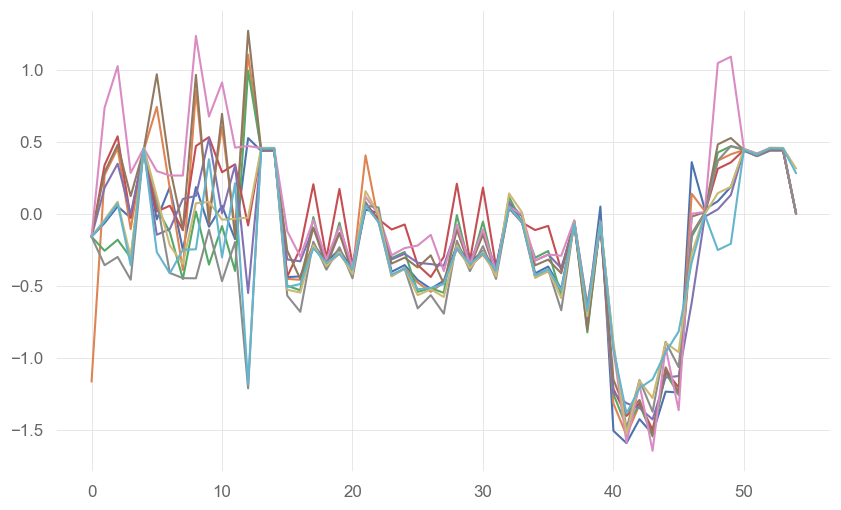

In [16]:
for i in range(10):
    plt.plot(X.to_numpy()[i])

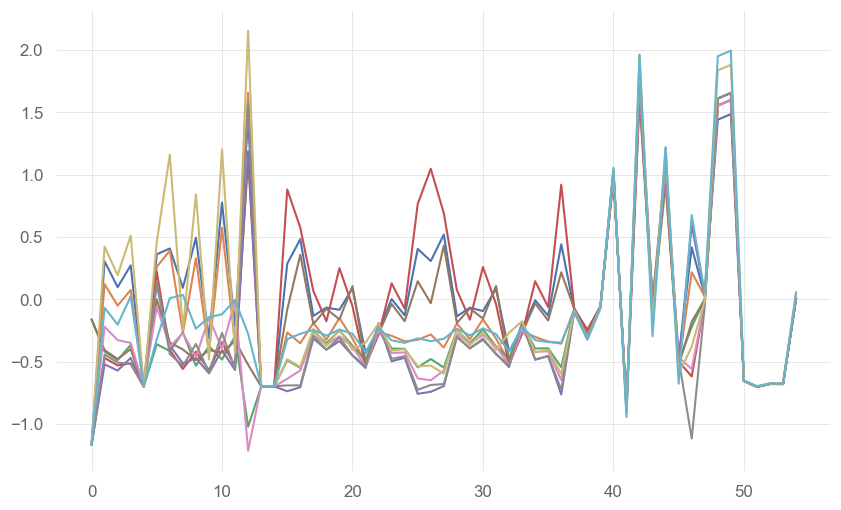

In [17]:
for i in range(10):
    plt.plot(X_val.to_numpy()[i])

# Оценка параметров

Модель отобрала 25 признаков; всего 55
                 vol:0.0
                 val:0.0
              trades:0.0
             pr_vwap:0.0
               val_s:-0.0
           pr_vwap_b:0.0
           pr_vwap_s:0.0
        put_orders_s:0.0
           put_val_b:-0.0
           put_vol_b:0.0
           put_vol_s:-0.0
          put_vwap_b:-0.0
             put_vol:0.0
             put_val:0.0
          put_orders:-0.0
        cancel_val_b:0.0
        cancel_val_s:0.0
       cancel_vwap_s:-0.0
          cancel_vol:0.0
          cancel_val:0.0
       cancel_orders:-0.0
          spread_bbo:-0.0
         spread_1mio:-0.0
            ob_vol_s:0.0
            ob_val_b:-0.0
   imbalance_val_bbo:-0.0
       imbalance_vol:0.0
              vwap_b:0.0
              vwap_s:0.0
         vwap_s_1mio:0.0
           put_val_s:0.00040083838262874963
            ob_val_s:0.00047871140047045437
       cancel_vwap_b:-0.0019532085987768533
               val_b:0.0034988861474657485
          put_vwap_s:-0.0

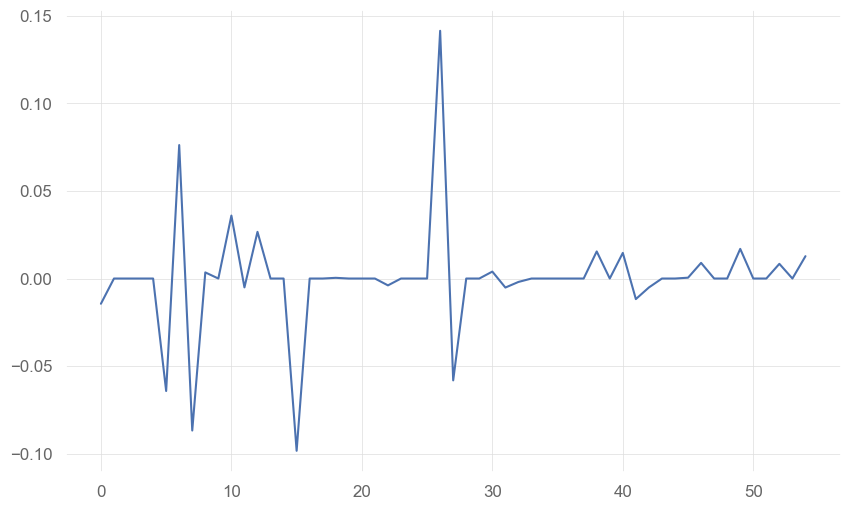

In [18]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.001)
clf.fit(X_train, Y_train)
count = 0
for i in clf.coef_:
    if i != 0:
        count += 1
print(f'Модель отобрала {count} признаков; всего {len(X_train.columns)}')
results1 = sorted(zip(metriks,clf.coef_), key=lambda x: abs(x[1]))
for name , coef in results1:
    print(f"{name:>20s}:{coef}")
plt.plot(clf.coef_)

pr_change:., Score: 0.04804
trend:., Score: 0.03498
trades_s:., Score: 0.02574
trades_b:., Score: 0.02437
disb:., Score: 0.02413
vol_b:., Score: 0.02265
trades:., Score: 0.02151
vol_s:., Score: 0.02149
levels_b:., Score: 0.02142
levels_s:., Score: 0.02137
val_b:., Score: 0.02125
cancel_vol_b:., Score: 0.02090
val_s:., Score: 0.02064
cancel_vol_s:., Score: 0.02026
vol:., Score: 0.02017
put_vol_s:., Score: 0.01943
put_vol_b:., Score: 0.01919
cancel_orders_s:., Score: 0.01904
val:., Score: 0.01894
imbalance_val_bbo:., Score: 0.01890
imbalance_vol_bbo:., Score: 0.01884
cancel_val_b:., Score: 0.01867
ob_val_b:., Score: 0.01863
put_orders_s:., Score: 0.01861
ob_vol_s:., Score: 0.01855
ob_vol_b:., Score: 0.01844
ob_val_s:., Score: 0.01839
put_val_b:., Score: 0.01827
cancel_orders_b:., Score: 0.01798
cancel_val_s:., Score: 0.01776
put_orders_b:., Score: 0.01776
put_val_s:., Score: 0.01720
spread_1mio:., Score: 0.01716
put_orders:., Score: 0.01686
cancel_orders:., Score: 0.01651
imbalance_val:.

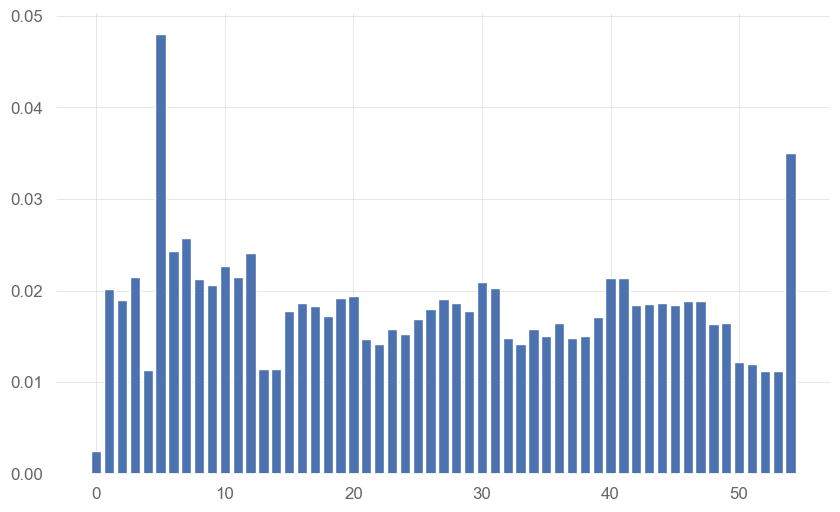

real is 1;  predicted is 1
real is 0;  predicted is 1
real is 1;  predicted is 1
real is 1;  predicted is 0
real is 1;  predicted is 1
real is 0;  predicted is 0
real is 1;  predicted is 0
real is 1;  predicted is 1
real is 1;  predicted is 1
real is 1;  predicted is 1
--------
train 1.0
test 0.6053093337861549


In [19]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

model = RandomForestClassifier()
model.fit(X, Y)
importance = model.feature_importances_
fotures = list(zip(X.columns,importance))
fotures.sort(key= lambda x: abs(x[1]),reverse=True)
for i,v in fotures:
    print('%s:., Score: %.5f' % (i,v))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
yhat = model.predict(X_val)
for i in range(10):
    print("real is "+str(Y.to_numpy()[i])+";  predicted is "+str(yhat[i]))
score_test=model.score(X_val,Y_val)
score_train=model.score(X, Y)
print("--------")
print("train "+str(score_train))
print("test "+str(score_test))

pr_change:., Score: 0.16090
trades_b:., Score: 0.06529
trades:., Score: 0.05447
trend:., Score: 0.05134
trades_s:., Score: 0.03147
vol:., Score: 0.02564
vol_b:., Score: 0.02496
ob_vol_s:., Score: 0.02463
spread_lv10:., Score: 0.02437
pr_std:., Score: 0.02293
spread_bbo:., Score: 0.02289
vol_s:., Score: 0.02195
cancel_vol_b:., Score: 0.02080
disb:., Score: 0.01987
cancel_vol_s:., Score: 0.01981
put_vol_b:., Score: 0.01824
cancel_vwap_b:., Score: 0.01669
put_vol_s:., Score: 0.01651
put_val_b:., Score: 0.01640
cancel_val_b:., Score: 0.01630
val_b:., Score: 0.01613
cancel_vwap_s:., Score: 0.01486
val:., Score: 0.01473
spread_1mio:., Score: 0.01426
cancel_vol:., Score: 0.01327
levels_s:., Score: 0.01317
put_orders:., Score: 0.01218
put_orders_b:., Score: 0.01193
levels_b:., Score: 0.01185
imbalance_vol:., Score: 0.01175
put_vol:., Score: 0.01088
cancel_orders_b:., Score: 0.01072
cancel_orders:., Score: 0.01047
ob_val_s:., Score: 0.01041
ob_val_b:., Score: 0.01037
put_orders_s:., Score: 0.00

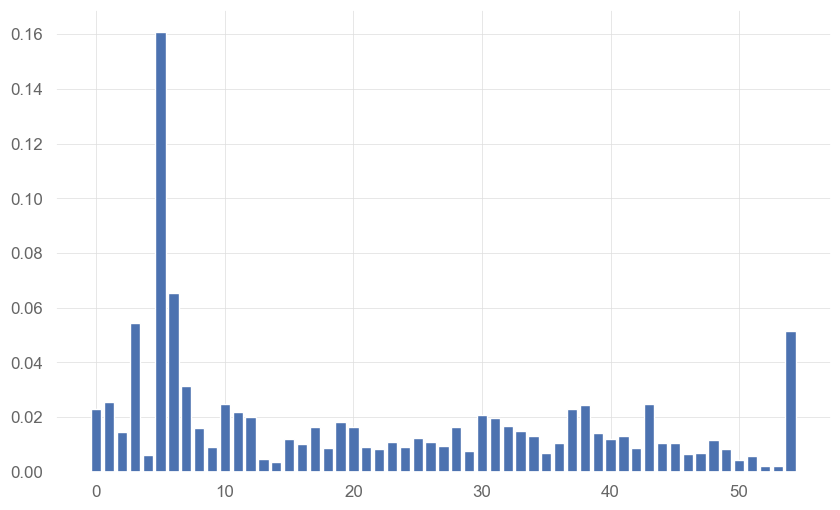

real is 0.0462;  predicted is 0.16050999999999996
real is 0.104;  predicted is -0.0037360000000000114
real is 0.075;  predicted is 0.1701859999999999
real is -0.1038;  predicted is 0.04859600000000003
real is 0.0635;  predicted is 0.009101000000000005
real is 0.0346;  predicted is -0.01010999999999999
real is 0.0;  predicted is 0.20844500000000007
real is -0.0173;  predicted is 0.05478199999999999
real is 0.0404;  predicted is 0.03378800000000002
real is 0.1326;  predicted is 0.025471999999999984
--------
train 0.8833487527681417
test -10.305377613320095


In [20]:
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
model = RandomForestRegressor()
model.fit(X, Y_reg)
importance = model.feature_importances_
fotures = list(zip(X.columns,importance))
fotures.sort(key= lambda x: abs(x[1]),reverse=True)
for i,v in fotures:
    print('%s:., Score: %.5f' % (i,v))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
score_test=model.score(X_val,Y_val_reg)
score_train=model.score(X, Y_reg)
yhat = model.predict(X)
for i in range(10):
    print("real is "+str(Y_val_reg.to_numpy()[i])+";  predicted is "+str(yhat[i]))

print("--------")
print("train "+str(score_train))
print("test "+str(score_test))

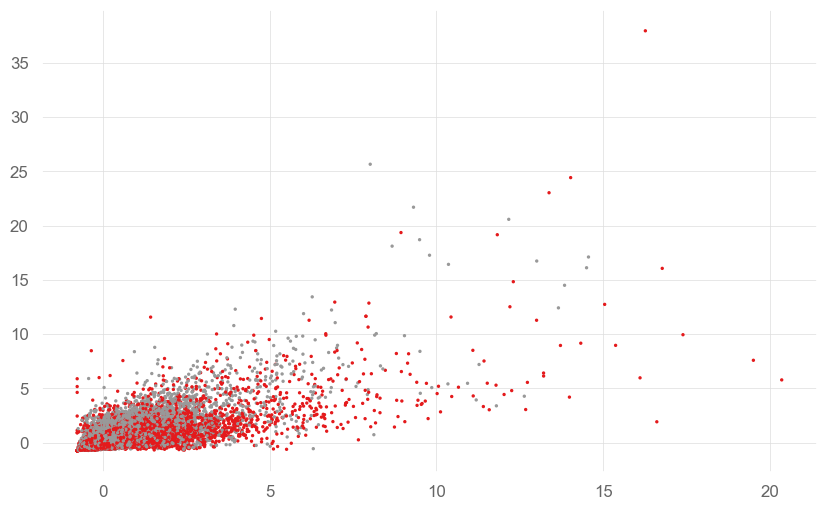

In [21]:
plt.scatter(list(X_train["trades_s"]), list(X_train["trades_b"]),c=Y_train, s=2,cmap="Set1")

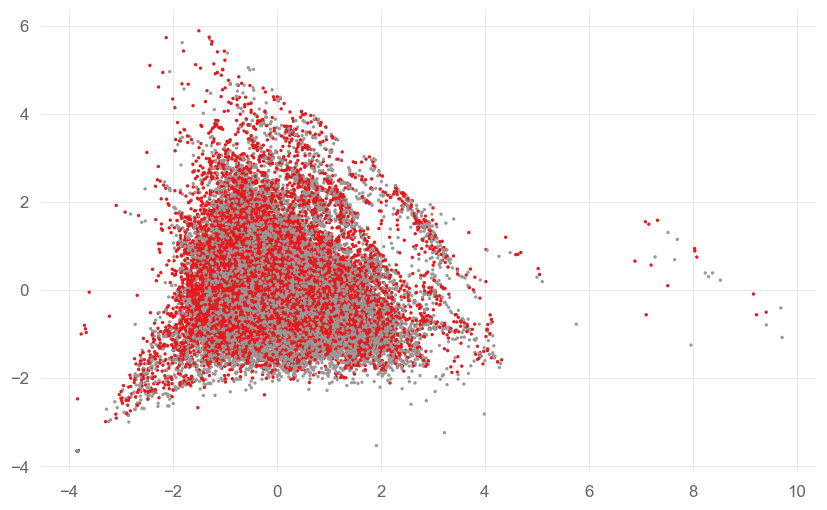

In [22]:
plt.scatter(list(X_train["levels_b"]), list(X_train["levels_s"]),c=Y_train, s=2,cmap="Set1")

In [23]:
from models.evaluation import *

# Обучение простого классификатора

--------
train 0.7145080757646203
test 0.5450214612518277
val 0.5249334918209091
KNN Bar Classifire
Количество предсказанных нулей 9410/9223
Количество предсказанных единиц 8257/8444
LABEL : 0
Presision для 0 = 0.5441020191285866
Recall для 0 = 0.555133904369511
F-Score для 0 = 0.5495626039821822
Примеров для 0 = 9223
------------------------------
LABEL : 1
Presision для 1 = 0.5030882887247184
Recall для 1 = 0.49194694457603033
F-Score для 1 = 0.4974552422010658
Примеров для 1 = 8444
------------------------------
Accuracy: 0.5249334918209091
Presision: 0.5030882887247184 доля действительно True из всех True
Recall: 0.49194694457603033 надейно всех положительных классов
F1 score: 0.4974552422010658


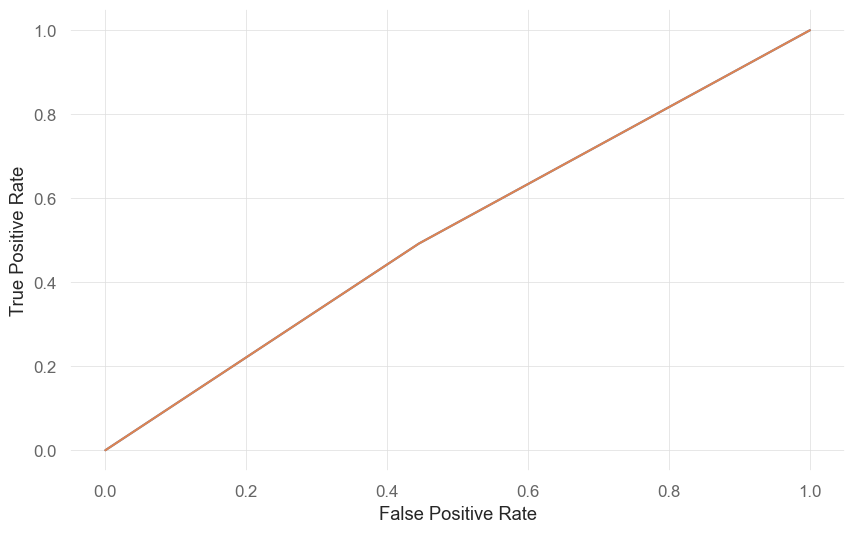

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
KNN = KNeighborsClassifier()
KNN.fit(X_train,Y_train)
score_train=KNN.score(X_train,Y_train)
score_test=KNN.score(X_test,Y_test)
score_val=KNN.score(X_val,Y_val)
print("--------")
print("train "+str(score_train))
print("test "+str(score_test))
print("val "+str(score_val))
evaluation(Y_val,KNN.predict(X_val),"KNN Bar Classifire")

## AutoML

In [25]:
from flaml import AutoML
automl = AutoML()
automl_settings = {
    "time_budget": 300,  # in seconds
    "metric": 'accuracy',
    "task": 'classification',
}
# Train with labeled input data
automl.fit(X_train=X_train, y_train=Y_train,
           **automl_settings)

[flaml.automl.logger: 12-09 23:21:32] {1679} INFO - task = classification
[flaml.automl.logger: 12-09 23:21:32] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-09 23:21:32] {1788} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 12-09 23:21:32] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 12-09 23:21:32] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-09 23:21:32] {2344} INFO - Estimated sufficient time budget=1975s. Estimated necessary time budget=46s.
[flaml.automl.logger: 12-09 23:21:32] {2391} INFO -  at 0.7s,	estimator lgbm's best error=0.4207,	best estimator lgbm's best error=0.4207
[flaml.automl.logger: 12-09 23:21:32] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-09 23:21:32] {2391} INFO -  at 0.8s,	estimator lgbm's best error=0.4207,	best estimator lgbm's best error=0.4207
[flaml.automl.logger: 12-09 2

[flaml.automl.logger: 12-09 23:21:34] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 12-09 23:21:35] {2391} INFO -  at 3.7s,	estimator lgbm's best error=0.3605,	best estimator lgbm's best error=0.3605
[flaml.automl.logger: 12-09 23:21:35] {2218} INFO - iteration 35, current learner lgbm
[flaml.automl.logger: 12-09 23:21:35] {2391} INFO -  at 3.9s,	estimator lgbm's best error=0.3605,	best estimator lgbm's best error=0.3605
[flaml.automl.logger: 12-09 23:21:35] {2218} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 12-09 23:21:35] {2391} INFO -  at 4.0s,	estimator extra_tree's best error=0.4298,	best estimator lgbm's best error=0.3605
[flaml.automl.logger: 12-09 23:21:35] {2218} INFO - iteration 37, current learner rf
[flaml.automl.logger: 12-09 23:21:35] {2391} INFO -  at 4.1s,	estimator rf's best error=0.4124,	best estimator lgbm's best error=0.3605
[flaml.automl.logger: 12-09 23:21:35] {2218} INFO - iteration 38, current learner xgboost
[f

[flaml.automl.logger: 12-09 23:21:42] {2218} INFO - iteration 70, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:21:43] {2391} INFO -  at 11.4s,	estimator xgb_limitdepth's best error=0.3599,	best estimator lgbm's best error=0.3599
[flaml.automl.logger: 12-09 23:21:43] {2218} INFO - iteration 71, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:21:43] {2391} INFO -  at 11.6s,	estimator xgb_limitdepth's best error=0.3599,	best estimator lgbm's best error=0.3599
[flaml.automl.logger: 12-09 23:21:43] {2218} INFO - iteration 72, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:21:43] {2391} INFO -  at 11.8s,	estimator xgb_limitdepth's best error=0.3599,	best estimator lgbm's best error=0.3599
[flaml.automl.logger: 12-09 23:21:43] {2218} INFO - iteration 73, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:21:43] {2391} INFO -  at 11.9s,	estimator xgb_limitdepth's best error=0.3599,	best estimator lgbm's best error=0.3599
[flaml.automl.lo

[flaml.automl.logger: 12-09 23:21:50] {2391} INFO -  at 19.1s,	estimator lgbm's best error=0.3599,	best estimator xgb_limitdepth's best error=0.3558
[flaml.automl.logger: 12-09 23:21:50] {2218} INFO - iteration 104, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:21:50] {2391} INFO -  at 19.2s,	estimator xgb_limitdepth's best error=0.3558,	best estimator xgb_limitdepth's best error=0.3558
[flaml.automl.logger: 12-09 23:21:50] {2218} INFO - iteration 105, current learner rf
[flaml.automl.logger: 12-09 23:21:51] {2391} INFO -  at 20.0s,	estimator rf's best error=0.3944,	best estimator xgb_limitdepth's best error=0.3558
[flaml.automl.logger: 12-09 23:21:51] {2218} INFO - iteration 106, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:21:52] {2391} INFO -  at 21.0s,	estimator xgb_limitdepth's best error=0.3554,	best estimator xgb_limitdepth's best error=0.3554
[flaml.automl.logger: 12-09 23:21:52] {2218} INFO - iteration 107, current learner xgb_limitdepth
[flaml

[flaml.automl.logger: 12-09 23:22:26] {2218} INFO - iteration 137, current learner lrl1
[flaml.automl.logger: 12-09 23:22:28] {2391} INFO -  at 57.3s,	estimator lrl1's best error=0.3805,	best estimator xgb_limitdepth's best error=0.3552
[flaml.automl.logger: 12-09 23:22:28] {2218} INFO - iteration 138, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:22:32] {2391} INFO -  at 60.9s,	estimator xgb_limitdepth's best error=0.3518,	best estimator xgb_limitdepth's best error=0.3518
[flaml.automl.logger: 12-09 23:22:32] {2218} INFO - iteration 139, current learner lgbm
[flaml.automl.logger: 12-09 23:22:32] {2391} INFO -  at 61.3s,	estimator lgbm's best error=0.3599,	best estimator xgb_limitdepth's best error=0.3518
[flaml.automl.logger: 12-09 23:22:32] {2218} INFO - iteration 140, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:22:34] {2391} INFO -  at 62.8s,	estimator xgb_limitdepth's best error=0.3518,	best estimator xgb_limitdepth's best error=0.3518
[flaml.autom

[flaml.automl.logger: 12-09 23:24:22] {2391} INFO -  at 170.7s,	estimator rf's best error=0.3813,	best estimator xgb_limitdepth's best error=0.3518
[flaml.automl.logger: 12-09 23:24:22] {2218} INFO - iteration 171, current learner lgbm
[flaml.automl.logger: 12-09 23:24:23] {2391} INFO -  at 171.9s,	estimator lgbm's best error=0.3599,	best estimator xgb_limitdepth's best error=0.3518
[flaml.automl.logger: 12-09 23:24:23] {2218} INFO - iteration 172, current learner rf
[flaml.automl.logger: 12-09 23:24:24] {2391} INFO -  at 172.7s,	estimator rf's best error=0.3813,	best estimator xgb_limitdepth's best error=0.3518
[flaml.automl.logger: 12-09 23:24:24] {2218} INFO - iteration 173, current learner extra_tree
[flaml.automl.logger: 12-09 23:24:24] {2391} INFO -  at 173.1s,	estimator extra_tree's best error=0.3904,	best estimator xgb_limitdepth's best error=0.3518
[flaml.automl.logger: 12-09 23:24:24] {2218} INFO - iteration 174, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:2

XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.537719913160517, colsample_bynode=None,
              colsample_bytree=0.9001015041678314, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.024302433492718795,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=11.617477282006774, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=912,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)
0.7201075420970708 0.644450733455969 0.6389879436237053
AutoML Bar classifire
Количество предсказанных нулей 11120/10968
Количество предсказанных единиц 10081/10233
LABEL : 0
Pres

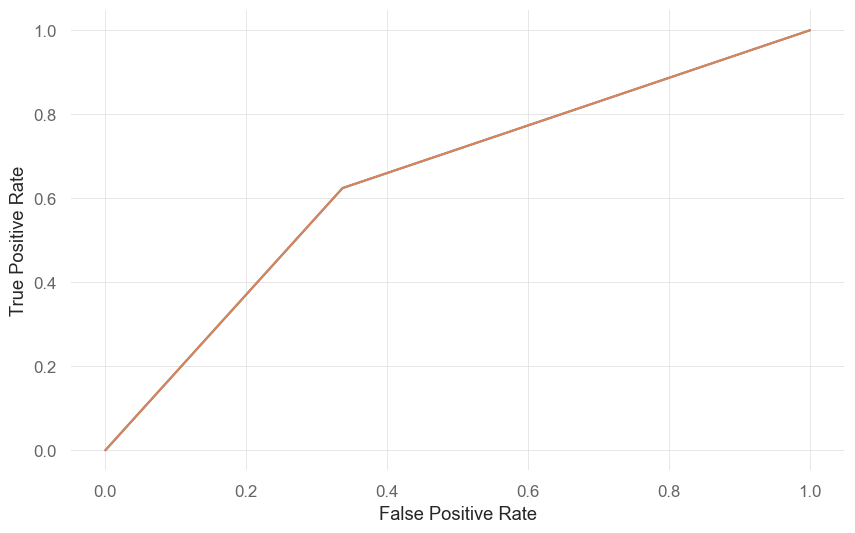

In [26]:
print(automl.model.estimator)
print(automl.model.score(X_train,Y_train) , automl.model.score(X_test,Y_test) , automl.model.score(X_val,Y_val))
evaluation(Y_test,automl.model.predict(X_test),'AutoML Bar classifire')

## Модель поддержки

In [27]:
def build_result_vector(predict,real):
    result = list()
    for predict , real in zip(predict,real):
        if predict == real:
            result.append(0)
        else:
            result.append(1)
    return np.array(result)

Y_train_model = build_result_vector(automl.model.predict(X_train),Y_train)
Y_test_model = build_result_vector(automl.model.predict(X_test),Y_test)
Y_val_model = build_result_vector(automl.model.predict(X_val),Y_val)

In [28]:
automl_validation = AutoML()
automl_settings = {
    "time_budget": 300,  # in seconds
    "metric": 'f1',
    "task": 'classification',
}
# Train with labeled input data
automl_validation.fit(X_train=X_test, y_train=Y_test_model,
           **automl_settings)

[flaml.automl.logger: 12-09 23:28:37] {1679} INFO - task = classification
[flaml.automl.logger: 12-09 23:28:37] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-09 23:28:37] {1788} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 12-09 23:28:37] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 12-09 23:28:37] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-09 23:28:37] {2344} INFO - Estimated sufficient time budget=491s. Estimated necessary time budget=11s.
[flaml.automl.logger: 12-09 23:28:37] {2391} INFO -  at 0.3s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl.logger: 12-09 23:28:37] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-09 23:28:37] {2391} INFO -  at 0.4s,	estimator lgbm's best error=1.0000,	best estimator lgbm's best error=1.0000
[flaml.automl.logger: 12-09 23:28:37

[flaml.automl.logger: 12-09 23:28:39] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 12-09 23:28:39] {2391} INFO -  at 2.2s,	estimator lgbm's best error=1.0000,	best estimator extra_tree's best error=0.9947
[flaml.automl.logger: 12-09 23:28:39] {2218} INFO - iteration 35, current learner rf
[flaml.automl.logger: 12-09 23:28:39] {2391} INFO -  at 2.4s,	estimator rf's best error=1.0000,	best estimator extra_tree's best error=0.9947
[flaml.automl.logger: 12-09 23:28:39] {2218} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 12-09 23:28:39] {2391} INFO -  at 2.4s,	estimator extra_tree's best error=0.9947,	best estimator extra_tree's best error=0.9947
[flaml.automl.logger: 12-09 23:28:39] {2218} INFO - iteration 37, current learner xgboost
[flaml.automl.logger: 12-09 23:28:39] {2391} INFO -  at 2.5s,	estimator xgboost's best error=1.0000,	best estimator extra_tree's best error=0.9947
[flaml.automl.logger: 12-09 23:28:39] {2218} INFO - iteration 

[flaml.automl.logger: 12-09 23:28:43] {2218} INFO - iteration 70, current learner xgboost
[flaml.automl.logger: 12-09 23:28:43] {2391} INFO -  at 6.0s,	estimator xgboost's best error=1.0000,	best estimator rf's best error=0.8734
[flaml.automl.logger: 12-09 23:28:43] {2218} INFO - iteration 71, current learner xgboost
[flaml.automl.logger: 12-09 23:28:43] {2391} INFO -  at 6.0s,	estimator xgboost's best error=1.0000,	best estimator rf's best error=0.8734
[flaml.automl.logger: 12-09 23:28:43] {2218} INFO - iteration 72, current learner xgboost
[flaml.automl.logger: 12-09 23:28:43] {2391} INFO -  at 6.1s,	estimator xgboost's best error=1.0000,	best estimator rf's best error=0.8734
[flaml.automl.logger: 12-09 23:28:43] {2218} INFO - iteration 73, current learner xgboost
[flaml.automl.logger: 12-09 23:28:43] {2391} INFO -  at 6.1s,	estimator xgboost's best error=1.0000,	best estimator rf's best error=0.8734
[flaml.automl.logger: 12-09 23:28:43] {2218} INFO - iteration 74, current learner xg

[flaml.automl.logger: 12-09 23:28:52] {2391} INFO -  at 15.1s,	estimator xgb_limitdepth's best error=0.7628,	best estimator rf's best error=0.6612
[flaml.automl.logger: 12-09 23:28:52] {2218} INFO - iteration 107, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:28:52] {2391} INFO -  at 15.2s,	estimator xgb_limitdepth's best error=0.7628,	best estimator rf's best error=0.6612
[flaml.automl.logger: 12-09 23:28:52] {2218} INFO - iteration 108, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:28:52] {2391} INFO -  at 15.3s,	estimator xgb_limitdepth's best error=0.7628,	best estimator rf's best error=0.6612
[flaml.automl.logger: 12-09 23:28:52] {2218} INFO - iteration 109, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:28:52] {2391} INFO -  at 15.4s,	estimator xgb_limitdepth's best error=0.7628,	best estimator rf's best error=0.6612
[flaml.automl.logger: 12-09 23:28:52] {2218} INFO - iteration 110, current learner xgb_limitdepth
[flaml.automl.logger

[flaml.automl.logger: 12-09 23:29:01] {2391} INFO -  at 24.3s,	estimator xgb_limitdepth's best error=0.6318,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:01] {2218} INFO - iteration 140, current learner lgbm
[flaml.automl.logger: 12-09 23:29:01] {2391} INFO -  at 24.3s,	estimator lgbm's best error=0.9530,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:01] {2218} INFO - iteration 141, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:29:02] {2391} INFO -  at 25.1s,	estimator xgb_limitdepth's best error=0.6318,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:02] {2218} INFO - iteration 142, current learner lgbm
[flaml.automl.logger: 12-09 23:29:02] {2391} INFO -  at 25.2s,	estimator lgbm's best error=0.8019,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:02] {2218} INFO - iteration 143, current learner lgbm
[flaml.automl.logger: 

[flaml.automl.logger: 12-09 23:29:10] {2391} INFO -  at 32.8s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:10] {2218} INFO - iteration 174, current learner lrl1
[flaml.automl.logger: 12-09 23:29:11] {2391} INFO -  at 33.9s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:11] {2218} INFO - iteration 175, current learner lrl1
[flaml.automl.logger: 12-09 23:29:12] {2391} INFO -  at 35.0s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:12] {2218} INFO - iteration 176, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:29:12] {2391} INFO -  at 35.1s,	estimator xgb_limitdepth's best error=0.6318,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:12] {2218} INFO - iteration 177, current learner lrl1
[flaml.automl.logger: 12-09 23:2

[flaml.automl.logger: 12-09 23:29:28] {2218} INFO - iteration 208, current learner lrl1
[flaml.automl.logger: 12-09 23:29:29] {2391} INFO -  at 51.9s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:29] {2218} INFO - iteration 209, current learner lgbm
[flaml.automl.logger: 12-09 23:29:29] {2391} INFO -  at 52.1s,	estimator lgbm's best error=0.6324,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:29] {2218} INFO - iteration 210, current learner lgbm
[flaml.automl.logger: 12-09 23:29:29] {2391} INFO -  at 52.3s,	estimator lgbm's best error=0.6324,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:29] {2218} INFO - iteration 211, current learner lgbm
[flaml.automl.logger: 12-09 23:29:29] {2391} INFO -  at 52.4s,	estimator lgbm's best error=0.6324,	best estimator xgb_limitdepth's best error=0.6318
[flaml.automl.logger: 12-09 23:29:29] {2218} INFO - 

[flaml.automl.logger: 12-09 23:29:41] {2218} INFO - iteration 243, current learner lgbm
[flaml.automl.logger: 12-09 23:29:41] {2391} INFO -  at 64.0s,	estimator lgbm's best error=0.6302,	best estimator lgbm's best error=0.6302
[flaml.automl.logger: 12-09 23:29:41] {2218} INFO - iteration 244, current learner lgbm
[flaml.automl.logger: 12-09 23:29:41] {2391} INFO -  at 64.1s,	estimator lgbm's best error=0.6302,	best estimator lgbm's best error=0.6302
[flaml.automl.logger: 12-09 23:29:41] {2218} INFO - iteration 245, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:29:41] {2391} INFO -  at 64.2s,	estimator xgb_limitdepth's best error=0.6318,	best estimator lgbm's best error=0.6302
[flaml.automl.logger: 12-09 23:29:41] {2218} INFO - iteration 246, current learner lgbm
[flaml.automl.logger: 12-09 23:29:41] {2391} INFO -  at 64.2s,	estimator lgbm's best error=0.6302,	best estimator lgbm's best error=0.6302
[flaml.automl.logger: 12-09 23:29:41] {2218} INFO - iteration 247, curre

[flaml.automl.logger: 12-09 23:29:54] {2391} INFO -  at 76.6s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:29:54] {2218} INFO - iteration 278, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:29:54] {2391} INFO -  at 77.0s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:29:54] {2218} INFO - iteration 279, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:29:54] {2391} INFO -  at 77.4s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:29:54] {2218} INFO - iteration 280, current learner lrl1
[flaml.automl.logger: 12-09 23:29:56] {2391} INFO -  at 78.5s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:29:56] {2218} INFO - iteration 281, current learner xgb_lim

[flaml.automl.logger: 12-09 23:30:14] {2391} INFO -  at 97.5s,	estimator extra_tree's best error=0.9947,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:30:14] {2218} INFO - iteration 311, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:30:15] {2391} INFO -  at 97.8s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:30:15] {2218} INFO - iteration 312, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:30:15] {2391} INFO -  at 98.0s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:30:15] {2218} INFO - iteration 313, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:30:15] {2391} INFO -  at 98.4s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:30:15] {2218} INFO - iteration 314, current

[flaml.automl.logger: 12-09 23:30:31] {2218} INFO - iteration 343, current learner lrl1
[flaml.automl.logger: 12-09 23:30:32] {2391} INFO -  at 115.4s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:30:32] {2218} INFO - iteration 344, current learner lrl1
[flaml.automl.logger: 12-09 23:30:33] {2391} INFO -  at 116.5s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:30:33] {2218} INFO - iteration 345, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:30:34] {2391} INFO -  at 116.9s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:30:34] {2218} INFO - iteration 346, current learner lrl1
[flaml.automl.logger: 12-09 23:30:35] {2391} INFO -  at 118.0s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 

[flaml.automl.logger: 12-09 23:30:55] {2391} INFO -  at 138.2s,	estimator xgboost's best error=0.9085,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:30:55] {2218} INFO - iteration 377, current learner lgbm
[flaml.automl.logger: 12-09 23:30:55] {2391} INFO -  at 138.2s,	estimator lgbm's best error=0.6302,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:30:55] {2218} INFO - iteration 378, current learner xgboost
[flaml.automl.logger: 12-09 23:30:55] {2391} INFO -  at 138.3s,	estimator xgboost's best error=0.7663,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:30:55] {2218} INFO - iteration 379, current learner xgboost
[flaml.automl.logger: 12-09 23:30:55] {2391} INFO -  at 138.4s,	estimator xgboost's best error=0.7663,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:30:55] {2218} INFO - iteration 380, current learner xgboost
[flaml.automl.logger: 12-09 23

[flaml.automl.logger: 12-09 23:31:18] {2218} INFO - iteration 410, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:31:19] {2391} INFO -  at 162.2s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:31:19] {2218} INFO - iteration 411, current learner lrl1
[flaml.automl.logger: 12-09 23:31:20] {2391} INFO -  at 163.3s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:31:20] {2218} INFO - iteration 412, current learner xgboost
[flaml.automl.logger: 12-09 23:31:40] {2391} INFO -  at 182.8s,	estimator xgboost's best error=0.6306,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:31:40] {2218} INFO - iteration 413, current learner extra_tree
[flaml.automl.logger: 12-09 23:31:40] {2391} INFO -  at 182.9s,	estimator extra_tree's best error=0.9947,	best estimator xgb_limitdepth's best error=0.6054
[flaml.aut

[flaml.automl.logger: 12-09 23:31:59] {2391} INFO -  at 201.9s,	estimator lgbm's best error=0.6302,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:31:59] {2218} INFO - iteration 444, current learner lrl1
[flaml.automl.logger: 12-09 23:32:00] {2391} INFO -  at 203.0s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:32:00] {2218} INFO - iteration 445, current learner rf
[flaml.automl.logger: 12-09 23:32:00] {2391} INFO -  at 203.3s,	estimator rf's best error=0.6597,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:32:00] {2218} INFO - iteration 446, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:32:01] {2391} INFO -  at 204.1s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:32:01] {2218} INFO - iteration 447, current learner lgbm
[flaml.automl.logger: 12-09 23:3

[flaml.automl.logger: 12-09 23:32:20] {2218} INFO - iteration 477, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:32:21] {2391} INFO -  at 223.9s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:32:21] {2218} INFO - iteration 478, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:32:21] {2391} INFO -  at 224.4s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:32:21] {2218} INFO - iteration 479, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:32:22] {2391} INFO -  at 224.8s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:32:22] {2218} INFO - iteration 480, current learner lrl1
[flaml.automl.logger: 12-09 23:32:23] {2391} INFO -  at 225.9s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best e

[flaml.automl.logger: 12-09 23:32:39] {2218} INFO - iteration 510, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:32:39] {2391} INFO -  at 242.3s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:32:39] {2218} INFO - iteration 511, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:32:40] {2391} INFO -  at 242.6s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:32:40] {2218} INFO - iteration 512, current learner lrl1
[flaml.automl.logger: 12-09 23:32:41] {2391} INFO -  at 243.7s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:32:41] {2218} INFO - iteration 513, current learner xgboost
[flaml.automl.logger: 12-09 23:32:41] {2391} INFO -  at 244.4s,	estimator xgboost's best error=0.6306,	best estimator xgb_limitdepth's best error=0.6054
[f

[flaml.automl.logger: 12-09 23:33:00] {2391} INFO -  at 262.8s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:33:00] {2218} INFO - iteration 544, current learner lgbm
[flaml.automl.logger: 12-09 23:33:00] {2391} INFO -  at 262.9s,	estimator lgbm's best error=0.6302,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:33:00] {2218} INFO - iteration 545, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:33:00] {2391} INFO -  at 263.5s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:33:00] {2218} INFO - iteration 546, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:33:01] {2391} INFO -  at 263.7s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:33:01] {2218} INFO - iteration 547, current learner xgb

[flaml.automl.logger: 12-09 23:33:17] {2391} INFO -  at 280.0s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:33:17] {2218} INFO - iteration 577, current learner lrl1
[flaml.automl.logger: 12-09 23:33:18] {2391} INFO -  at 281.1s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:33:18] {2218} INFO - iteration 578, current learner lrl1
[flaml.automl.logger: 12-09 23:33:19] {2391} INFO -  at 282.2s,	estimator lrl1's best error=0.9974,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:33:19] {2218} INFO - iteration 579, current learner xgb_limitdepth
[flaml.automl.logger: 12-09 23:33:19] {2391} INFO -  at 282.5s,	estimator xgb_limitdepth's best error=0.6054,	best estimator xgb_limitdepth's best error=0.6054
[flaml.automl.logger: 12-09 23:33:19] {2218} INFO - iteration 580, current learner xgb_limitdepth
[flaml.a

[flaml.automl.logger: 12-09 23:33:37] {2630} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.8148812804600302, colsample_bynode=None,
              colsample_bytree=0.8462712092193052, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=0.3369411498795218, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=45,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)
[flaml.automl.logger: 12-09 23:33:37] {1930} INFO - fit succeeded
[flaml.automl.logger: 12-09 23:33:37] {1931} INFO - Time take

XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.8148812804600302, colsample_bynode=None,
              colsample_bytree=0.8462712092193052, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=0.3369411498795218, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=45,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)
AutoML validation model
Количество предсказанных нулей 10164/11289
Количество предсказанных единиц 7503/6378
LABEL : 0
Presision для 0 = 0.654073199527745
Recall для 0 = 0.5888918416157322
F-Score

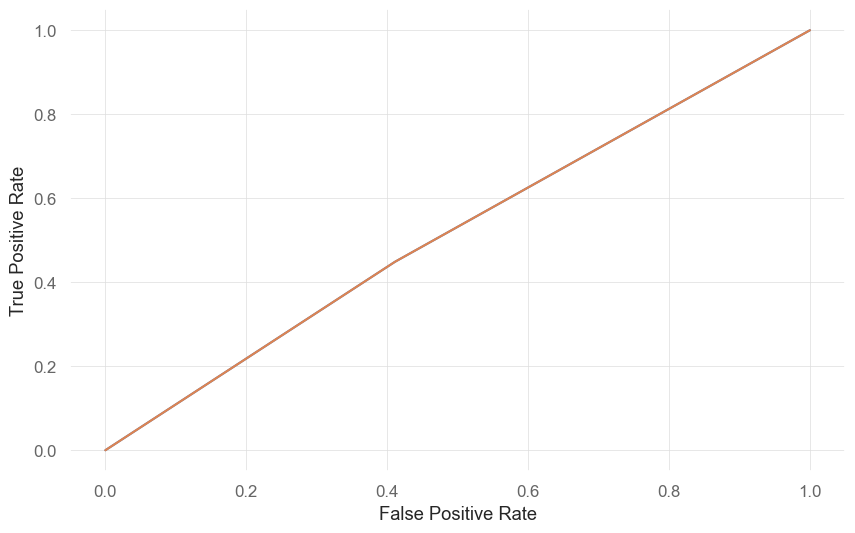

In [29]:
print(automl_validation.model.estimator)
preds = automl_validation.model.predict(X_val)
evaluation(Y_val_model,preds,'AutoML validation model')

### Результаты

Результаты
Количество предсказанных нулей 3844/3812
Количество предсказанных единиц 3659/3691
LABEL : 0
Presision для 0 = 0.6235691987513007
Recall для 0 = 0.628803777544596
F-Score для 0 = 0.6261755485893417
Примеров для 0 = 3812
------------------------------
LABEL : 1
Presision для 1 = 0.6132823175731074
Recall для 1 = 0.6079653210512056
F-Score для 1 = 0.6106122448979592
Примеров для 1 = 3691
------------------------------
Accuracy: 0.6185525789684126
Presision: 0.6132823175731074 доля действительно True из всех True
Recall: 0.6079653210512056 надейно всех положительных классов
F1 score: 0.6106122448979592


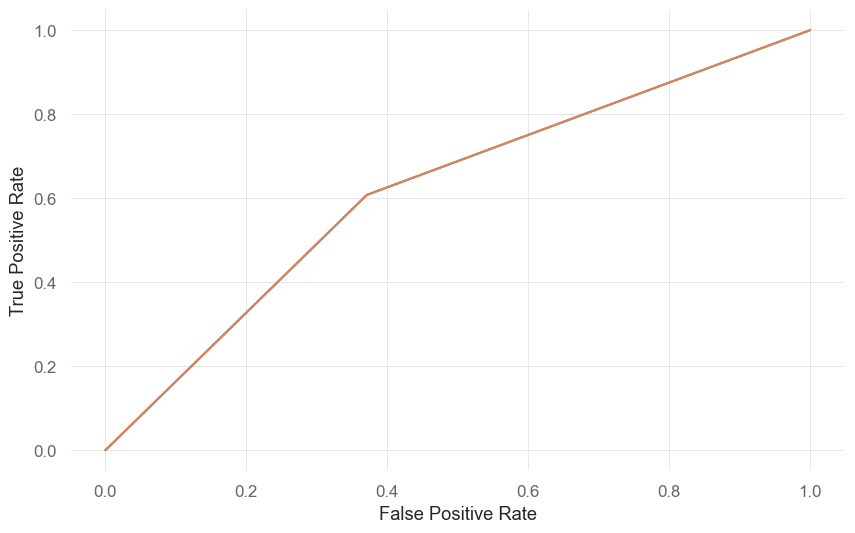

0.6185525789684126


In [30]:
val_preds = automl.model.predict(X_val)
val_preds_error = automl_validation.model.predict(X_val)
res = []
pred = []
for preds , error , result in zip(val_preds,val_preds_error,Y_val):
    if error == 1:
        res.append(preds)
        pred.append(result)
    else:
        pass
evaluation(res,pred,'Результаты')
print(sklearn.metrics.accuracy_score(res, pred))

## Извлечениепризнаков

Epoch 1/20
3092/3092 - 18s - loss: 0.3226 - val_loss: 0.1817 - 18s/epoch - 6ms/step
Epoch 2/20
3092/3092 - 15s - loss: 0.2173 - val_loss: 0.1584 - 15s/epoch - 5ms/step
Epoch 3/20
3092/3092 - 15s - loss: 0.1885 - val_loss: 0.2412 - 15s/epoch - 5ms/step
Epoch 4/20
3092/3092 - 15s - loss: 0.1711 - val_loss: 0.1975 - 15s/epoch - 5ms/step
Epoch 5/20
3092/3092 - 15s - loss: 0.1542 - val_loss: 0.1045 - 15s/epoch - 5ms/step
Epoch 6/20
3092/3092 - 15s - loss: 0.1501 - val_loss: 0.1779 - 15s/epoch - 5ms/step
Epoch 7/20
3092/3092 - 15s - loss: 0.1345 - val_loss: 0.1130 - 15s/epoch - 5ms/step
Epoch 8/20
3092/3092 - 16s - loss: 0.1361 - val_loss: 0.1409 - 16s/epoch - 5ms/step
Epoch 9/20
3092/3092 - 16s - loss: 0.1258 - val_loss: 0.1084 - 16s/epoch - 5ms/step
Epoch 10/20
3092/3092 - 15s - loss: 0.1228 - val_loss: 0.0979 - 15s/epoch - 5ms/step
Epoch 11/20
3092/3092 - 15s - loss: 0.1226 - val_loss: 0.0948 - 15s/epoch - 5ms/step
Epoch 12/20
3092/3092 - 15s - loss: 0.1115 - val_loss: 0.0874 - 15s/epoch 

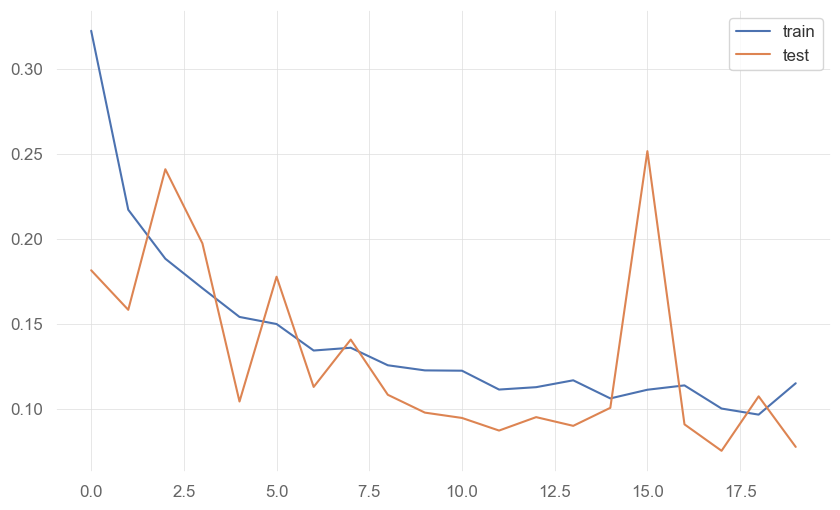

In [31]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

n_inputs = len(X_train.to_numpy()[0])
# Определим кодировшик
visible = Input(shape=(n_inputs,))
# первый  слой
e = Dense(n_inputs*3)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# второй слой
e = Dense(n_inputs*2)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# Определим декодер
n_bottleneck = int(n_inputs / 1.5)
bottleneck = Dense(n_bottleneck)(e)
# декодер первый слой
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# декодер второй слой
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# выходной слой
output = Dense(n_inputs, activation='linear')(d)
# Определим модель автокодировшика
AutoEncoderModel = Model(inputs=visible, outputs=output)
# Скомпилируем модель
AutoEncoderModel.compile(optimizer='adam', loss='mse')

#визуализации
history = AutoEncoderModel.fit(X_train, X_train, epochs=20, batch_size=16, verbose=2, validation_data=(X_val,X_val))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [33]:
from sklearn.metrics import mean_squared_error

In [50]:
mse_train =list()
mse_val = list()
pred_train = AutoEncoderModel.predict(X_train)
pred_val = AutoEncoderModel.predict(X_val)
xnp = X_train.to_numpy()
xv_np = X_val.to_numpy()
for i in range(len(xnp)):
    mse_train.append(mean_squared_error(xnp[i],pred_train[i]))
for i in range(len(xv_np)):
    mse_val.append(mean_squared_error(xv_np[i],pred_val[i]))

553/553 [==============================] - 1s 2ms/step


In [55]:
max(mse_train) , max(mse_val)

(186.1541339665263, 106.01409590602945)

In [57]:
def mean(array):
    return sum(array) / len(array)

In [58]:
max(mse_train) , max(mse_val)

(186.1541339665263, 106.01409590602945)

In [59]:
mean(mse_train) , mean(mse_val)

(0.06653652287048213, 0.07774362283675602)

## User Guard Autoencoder based

Заметим, что на валидации ошибка востановления больше, нам следует взять ошибку валидации за некий коэффициент, 
при значительном отклонении от которого в большую сторону. Т.е ошибка востановления больше средней на валидации 
с некоторым допущением -> считаем что изменилась природа входных данных и модель их ранее не видела. А значит другая 
модель или стартегия (время бэктеста) не протестированы на работе на этих данных. Следовательно работа алгоритма в таком 
случае носит случайный характер. 

In [61]:
encoder = Model(inputs=visible, outputs=bottleneck)
pr = encoder.predict(X_train)
pr_dec = AutoEncoderModel.predict(X_train)
import matplotlib.pyplot as plt
plt.plot(X_train.to_numpy()[5][:30])
plt.plot(pr_dec[5][:30])
#plt.plot(pr[5])

1546/1546 [==============================] - 2s 2ms/step


## Кластерный анализ

  0%|          | 0/49 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


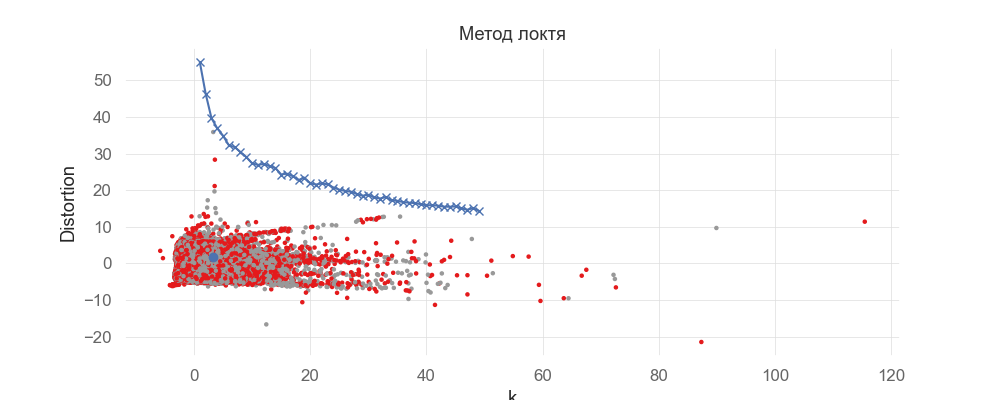

<IPython.core.display.Javascript object>


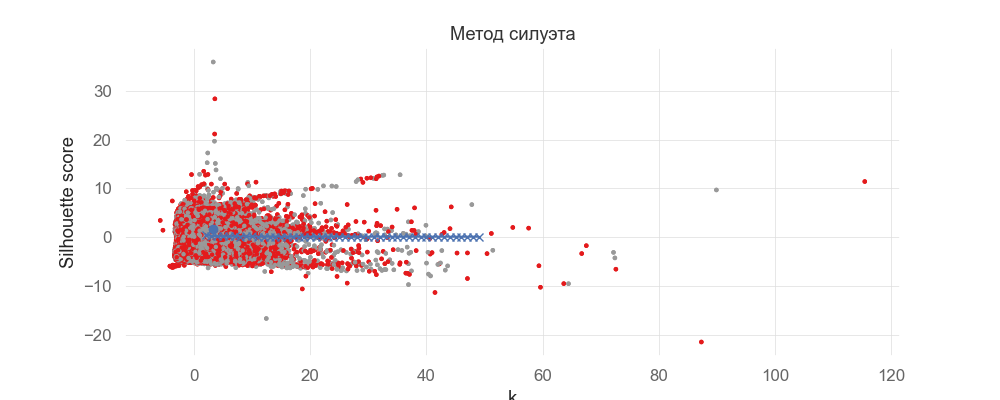

In [62]:
from tqdm.autonotebook import tqdm
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
distortions = []
silhouette = []
K = range(1, 50)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10)
    kmeanModel.fit(X)
    #pickle.dump(kmeanModel,open('models/kmeans_euclidean2_'+str(k), 'wb'))
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(X, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Метод локтя')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Метод силуэта')
plt.show()

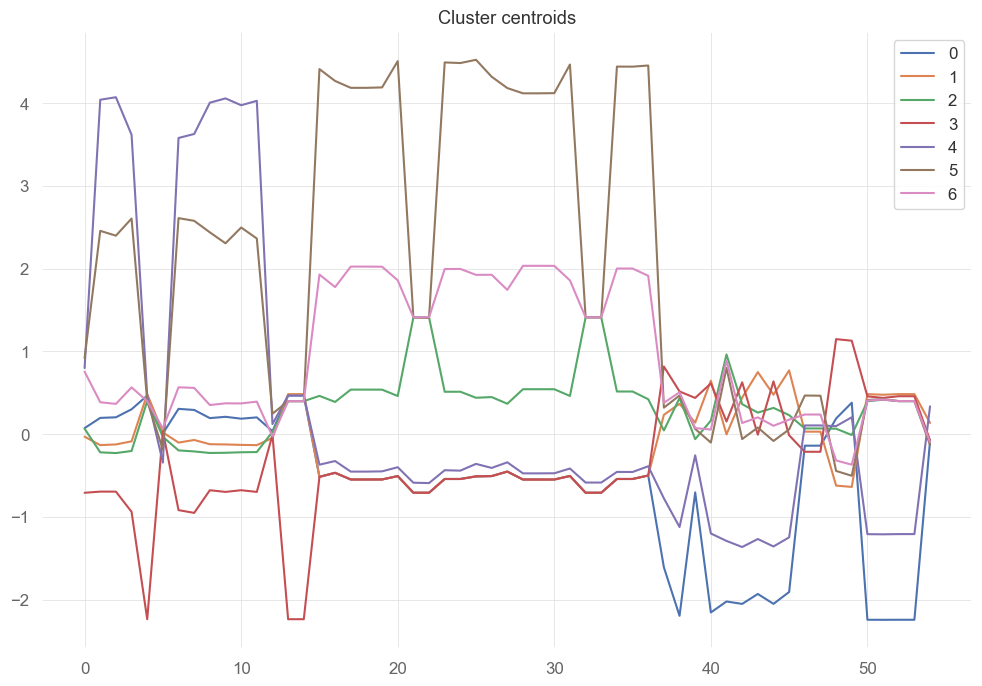

In [165]:
n_clusters = 6
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(X)
plt.figure(figsize=(12,8))
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [166]:
len(X_val)

311

In [167]:
X_cluster = X.copy()
X_cluster['class'] = ts_kmeans.predict(X)
X_cluster['result'] = list(Y)

X_cluster_val = X_val.copy()
X_cluster_val['class'] = ts_kmeans.predict(X_cluster_val)
X_cluster_val['result'] = list(Y_val)

score = []
score_val = []
for i in tqdm(range(n_clusters)):
    try:
        df = X_cluster[X_cluster['class'] == i]
        Yc = list(df['result'])
        del(df['result'])
        
        df_val = X_cluster_val[X_cluster_val['class'] == i]
        Yv = list(df_val['result'])
        del(df_val['result'])
        
        model = KNeighborsClassifier()
        model.fit(df,Yc)
        _score_train = model.score(df,Yc)
        _score_val = model.score(df_val,Yv)
        print(f"Класс {i}: {_score_train} ; Валидация: {_score_val}")
        score.append(_score_train)
        score_val.append(_score_val)
    except:
        pass
        #print(f"{i} кластер содержит недостаточно данных")
print(f"Средняя ошибка на тесте {sum(score)/len(score)} , средняя ошибка валидация {sum(score_val)/len(score_val)}")

  0%|          | 0/7 [00:00<?, ?it/s]

Класс 0: 0.6270270270270271 ; Валидация: 0.375
Класс 2: 0.7062937062937062 ; Валидация: 0.5747126436781609
Класс 5: 0.7777777777777778 ; Валидация: 0.5964912280701754
Класс 6: 0.7 ; Валидация: 0.5196078431372549
Средняя ошибка на тесте 0.7027746277746278 , средняя ошибка валидация 0.5164529287213978


In [168]:
cluster_number = 6

df_train = X_cluster[X_cluster['class'] == cluster_number]
Y_cluster = list(df_train['result'])
del(df_train['result'])

X_cluster_val = X_val.copy()
X_cluster_val['class'] = ts_kmeans.predict(X_val)
X_cluster_val['result'] = list(Y_val)

df_val = X_cluster_val[X_cluster_val['class'] == cluster_number]
Y_clustre_val = list(df_val['result'])
del(df_val['result'])

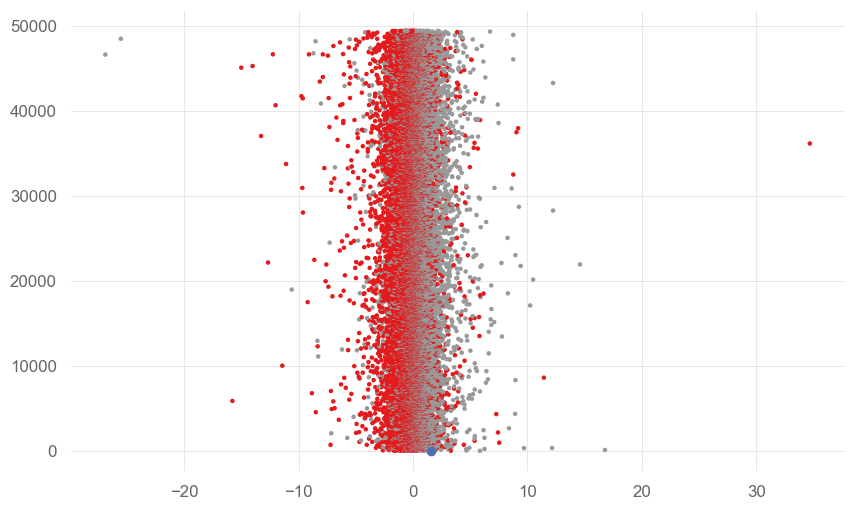

In [71]:
%matplotlib inline
model = plotLDA(X_train,Y_train,2)

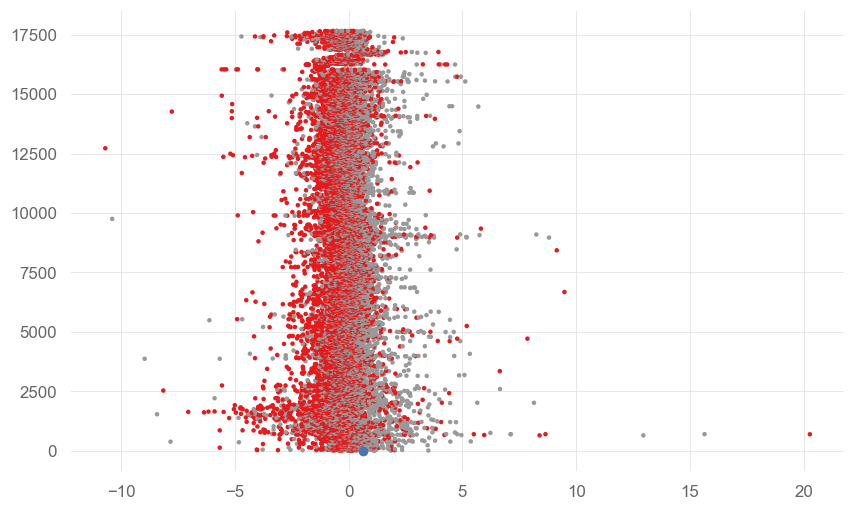

In [72]:
tddata = plotTransformData(model,X_val,Y_val)